# Code de création de data frame pour la catégorie Other

## I) Importation des bibliothèques

C:\Users\rollan\Documents\GPU_stage\pyNanoMatBuilder-main



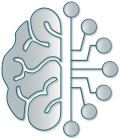

**Start at:** Thursday 05 September 2024, 13:13:52  
**Hostname:** insa-11557 (Windows)

<p style="text-align: center"><img width="800px" src="./styles/svg/pyNanoMatBuilder_banner.svg" style="margin-left:auto; margin-right:auto"/></p>

<module 'pyNanoMatBuilder.utils' from 'C:\\Users\\rollan\\AppData\\Local\\anaconda3\\envs\\py311\\Lib\\site-packages\\pyNanoMatBuilder\\utils.py'>

In [1]:
##################
# Initialization #
##################

import os
import sys

print(os.getcwd())
cwd0 = './styles/'
sys.path.append(cwd0)

import visualID as vID
from visualID import  fg, hl, bg
vID.init(cwd0)

import numpy as np
import ase
from ase.io import write
from ase.visualize import view

import pyNanoMatBuilder.utils as pNMBu
import importlib
import pandas as pd

from pyNanoMatBuilder import platonicNPs as pNP

import importlib
importlib.reload(pNP)
importlib.reload(pNMBu)

## II) Définition des fonctions nécessaires à la creation du data frame 

### Définition de la fonction clean

**Cette fonction a pour but de supprimer la ligne en trop des fichiers xyz que on va creer** 

In [2]:
def clean_xyz(filename):
    dtype = {'names': ('element', 'x', 'y', 'z'),
             'formats': ('U2', float, float, float)}    
    element,x,y,z=np.loadtxt(filename,unpack=True,skiprows=2 , usecols=(0, 1, 2, 3), dtype=dtype)
    outfile=os.path.dirname(filename)+'/'+os.path.basename(filename).split('.')[0]+'.xyz'
    nb_atoms=len(x)
    line2write=str(nb_atoms)+'\n'
    line2write+='\n'
    for i in range(nb_atoms):
        line2write+=str(element[i])+'\t %.8f'%x[i] + '\t %.8f'%y[i] + '\t %.8f'%z[i] +'\n'
    with open(outfile,'w') as file:
        file.write(line2write)
    return outfile

### Definition fonction verificationde la covariance

**Cette fonction vérifie que la matrice de covariance est bien symétrique definie positive**

In [3]:
import numpy as np

def check_covariance_params(esds):
    """
    Vérifie si les paramètres (écarts-types) sont valides pour créer une matrice de covariance
    symétrique définie positive.

    Args:
    esds (list or np.array): Une liste ou un tableau contenant trois valeurs d'écart type.

    Returns:
    bool: True si la matrice de covariance est définie positive, False sinon.
    """
    # Assurez-vous que l'entrée est un tableau numpy
    esds = np.array(esds)

    # Création de la matrice de covariance diagonale
    cov_matrix = np.diag(esds**2)

    # Vérification de la symétrie
    if not np.allclose(cov_matrix, cov_matrix.T):
        print("La matrice de covariance n'est pas symétrique.")
        return False

    # Vérification des valeurs propres
    eigvals = np.linalg.eigvals(cov_matrix)
    #print("Valeurs propres de la matrice de covariance:", eigvals)

    # Vérification de la positivité définie
    if np.any(eigvals <= 0):
        print("La matrice de covariance n'est pas définie positive.")
        return False

    return True

### Définition de la fonction Moment d'inertie

**Cette fonction a pour but de donner la liste des moments d'inertie par rapport à trois axes principaux**

In [4]:
def fmom_inertie(model):
    
        # model.get_moments_of_inertia() : Cette méthode est censée retourner les moments d'inertie du modèle.
        # Les moments d'inertie sont des quantités physiques mesurant la répartition de la masse par rapport à trois axes principaux. 
        # Ils sont généralement donnés en unités de amu⋅A˚2amu⋅A˚2 (masse atomique unifiée multipliée par le carré de la longueur en angströms).
        # La variable model.moi contient ces valeurs, souvent sous la forme d'un tableau ou d'une liste de trois valeurs correspondant aux moments d'inertie autour des trois axes principaux.
        model.moi = model.get_moments_of_inertia()  # en amu*angstrom**2
        # Pour arrondir chaque élément à deux décimales
        model.moi = [round(x, 2) for x in model.moi]
    
        return model.moi

**Autres possibilités avec le moment de inertie que on exploitra pas mais qui peuvent être utiles**

In [5]:
## model.get_masses() : Cette méthode retourne les masses des atomes du modèle. Typiquement, ces masses sont données en unités de masse atomique unifiée (amu).
## La variable model.masses est une liste ou un tableau contenant les masses de chaque atome dans le modèle.
#model.masses = model.get_masses()

## model.masses.sum() : Calcule la somme totale des masses de tous les atomes dans le modèle. Cela donne la masse totale du modèle, notée model.M
#model.M = model.masses.sum()

## model.moi / model.M : Divise les moments d'inertie par la masse totale pour obtenir les moments d'inertie normalisés. 
## Ces valeurs sont donc les moments d'inertie par unité de masse, ce qui peut être utile pour comparer des modèles de tailles différentes ou pour des calculs supplémentaires.
#model.moiM = model.moi/model.M

## np.sqrt(5 * model.moiM) : Calcule la racine carrée de cinq fois les moments d'inertie normalisés. Ce calcul est basé sur une approximation
## spécifique pour estimer les dimensions du modèle, généralement utilisée dans des contextes où les moments d'inertie sont utilisés pour déterminer la taille de l'objet.
## Cette formule peut être spécifique à un certain type de modèle ou d'application.
#model.dim = 2*np.sqrt(5*model.moiM)

      
#return model.moi.sum()  # Retourne la somme des moments d'inertie pour un usage simplifié

### Fonction extraction de pararmètre pour des tailles à plusieurs paramètres (2paramètre ici contrairement a 3 habituellement)

In [6]:
import pandas as pd

def extract_parameters_multi( Element, Shape, qmin, qmax, qstep, b_iso, df):
    # Filtrer le DataFrame en fonction des paramètres donnés
    filtered_df = df[
        (df['Element'] == Element) &
        (df['Shape'] == Shape) &
        (df['qmin'] == qmin) &
        (df['qmax'] == qmax) &
        (df['qstep'] == qstep) &
        (df['b_iso'] == b_iso)
    ]
    
    # Extraire les colonnes Size_parameters, q, et Intensities sous forme de listes
    size_parameters = filtered_df['Size_parameters'].tolist()
    intensities = filtered_df['Intensities'].tolist()


    # Convertir les listes de Size_parameters en liste des deux premiers éléments (car on veut pas [3,3,0] etc mais juste [3,3] par exemple)
    size_parameters = [t[:2] for t in size_parameters]
    
    

    return size_parameters, intensities

# Exemple d'utilisation
# Supposez que votre DataFrame est stocké dans la variable df
#size_parameters,intensities = extract_parameters('Ag', "cuboctahedron", 0.01, 20, 0.01, 0.1, df)

### Fonction générale polydispersité pour des tailles à plusieurs paramètres

In [7]:
import numpy as np
from scipy.stats import multivariate_normal
import os
from pathlib import Path
from scipy.stats import norm,cauchy
import numpy as np
import matplotlib.pyplot as plt


def polydis_multi(Element, Shape, qmin, qmax, qstep, biso, mean, esd, df="stage/Base_de_donnees_finale/fichier_global.pk"):


    ############################## PARAMETERS FOR MODEL GENERATION ##########################################################
  

    # Distribution normale multivariée pour les axes de l'ellipsoïde
    
    cov_matrix = np.diag([esd[0]**2, esd[1]**2])
    size_parameters, intensities = extract_parameters_multi(Element, Shape,qmin,qmax,qstep,biso,df)
    
    mvn = multivariate_normal(mean=mean, cov=cov_matrix)
    # Calcul de la pondération en fonction de la distribution multivariée
    y = mvn.pdf(np.array(size_parameters))


    #################################### Weighted summation of contributions to get average S(q) ########################    
    # Mutliply each S(q) by its corresponding weight
    index=0
    taille=int((qmax - qmin) / qstep) + 1
    iq_pol=np.zeros(taille)
    

    
    # Boucle sur chaque combinaison d'intensités
    for weight in y:
        
        ws=weight*np.array(intensities[index])
        iq_pol+=ws
        index+=1
    
    iq_pol=iq_pol.tolist()

    
    return iq_pol

### Définition de la fonction de gestion des datas frame pour la catégorie des solides autres

**Cette fonction a pour but de creer un data frame de une ligne contenant les arguments que on a donné**

In [32]:
def fonction_gestion_dataframe_shapes_other(element, forme, distance,nombre_couches,mean,esd,qmin=0.01,qmax=20,qstep=0.01,biso=0.01,endroit_fich_xyz='tempxyz.xyz'):
    """
    forme (trigonal_platelet ) -- string
    element (ex Au )-- string
    distance = distance entre plus proche voisin -- float
    nombre_couches: liste de trois éléments, le premier est le nombre de couche, le second est la longeur des bords et le dernier est nul --list integer
    qmin -- list 
    qmax -- list 
    qstep -- list 
    biso : pour simuler la vibration atomique et avoir des modèles plus réalistes -- list
    endroit_fich_xyz =  l'endroit ou on veut enregister notre fichier xyz qui sera creé pui supprimé durant l'exécution de la fonction --string
    """
    #on importe les bibliothèques utiles
    
    from pyNanoMatBuilder import crystalNPs as cyNP
    import numpy as np
    from pyNanoMatBuilder import platonicNPs as pNP
    from pyNanoMatBuilder import johnsonNPs as jNP
    import importlib
    import sys
    import pyNanoMatBuilder.utils as pNMBu
    from pyNanoMatBuilder import otherNPs as oNP
    import importlib
    from ase.io import write, read

    
    # Entrer l'endroit ou on veut enregister notre fichier xyz 
    fich_xyz=f"{endroit_fich_xyz}"

    
    # Création du DataFrame vide (que on viendra remplir dans la suite ) avec les colonnes spécifiées
    df = pd.DataFrame(columns=["Solid_class","Element", "Shape", "Distance","Size_parameters","Eq_Radius","moment_of_inertia","n_Atoms","polydispersity","qmin","qmax","qstep","b_iso","q","Intensities"])

    #Disjonction de cas selon les arguments (plus précisément la forme) que ont a rentés
    if forme != "trigonal_platelet" :
        print("La forme donnée n'est pas dans la classe des solides others")
              

    #cas pour le trigonal_platelet
    if forme == "trigonal_platelet" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        tpt = oNP.fcctpt(f"{element}",distance,nombre_couches[0],nombre_couches[1],aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write(fich_xyz, tpt.NP)
        try :
            r=tpt.radiusCircumscribedSphere()
        except :
            r=0  #pas encore de fonction radius pour cette classe, donc on rentre 0 par défaut
        
        n_Atoms=tpt.nAtoms
        
        
      
    
    #On utilise la fonction Clean sur le fichier xyz que on vient de creer 
    xyz_file=fich_xyz
    xyz_file=clean_xyz(xyz_file)

    # Calcul du moment d'inertie en utilisant le modèle
    structure = read(fich_xyz)  # Lecture de la structure à partir du fichier xyz
    Mom_inertie = fmom_inertie(structure)

    
    # On calcul I(q) avec la fonction debyecalculator et on rentre les tableau numpy générés dans les variable Q et I
    from debyecalculator import DebyeCalculator
    
    calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cuda',biso=0.01)
    Q, I = calc.iq(structure_source=xyz_file)

    ###### supression du fichier xyz pour garder seulement le nom
    os.remove(fich_xyz)


    # on rentrer nos arguments de fonction dans des variables
    df_pol = pd.read_pickle("stage/Base_de_donnees_finale/fichier_global.pk")
    Q=Q
    Distance =distance
    Element= f"{element}"
    Forme=f"{forme}"
    Type_solide= "Other"
    Rayon=r
    moment_inertie=Mom_inertie
    Qmin=qmin
    Qmax=qmax
    Qstep=qstep
    Biso=biso
    N_Atoms=n_Atoms

    
    if mean==[0,0] and esd==[0,0] :
        Polydispersity=list([0,0])
        Couche=nombre_couches
        Intensite=I
    else :
        Polydispersity=list([mean,esd])
        Couche=list([mean,0,0])
        #df = pd.read_pickle("stage/Base_de_donnees_finale/fichier_global.pk")
        Intensite=polydis_multi(element,forme,qmin,qmax,qstep,biso,esd,mean,df_pol)
        
    
    
    # On ajout une ligne au DataFrame (avec ce qu'on voulait dedans comme données) en utilisant loc
    df.loc[len(df)] = [Type_solide,Element, Forme, Distance, Couche,Rayon, moment_inertie,N_Atoms,Polydispersity,Qmin,Qmax,Qstep,Biso, Q,Intensite]
    
    
    return df  
    

    # On ajout une ligne au DataFrame (avec ce qu'on voulait dedans comme données) en utilisant loc
    df.loc[len(df)] = [Type_solide,Element, Forme, Distance, Nombre_couche,Rayon, moment_inertie,N_Atoms,Polydispersity,Qmin,Qmax,Qstep,Biso, Q,Intensite]
    
    
    return df  

### Définition de la fonction qui creer un fichier pk avec les paramètres qu'on veut 

**On utilise des boucles afin de parcourir toutes les formes, les éléments et le nombre de couche et d'atomes par bords souhaitées.**
**On va donc creer plusieurs data frame d'une ligne et on va les concatener au fur et a mesure pour obtenir un seul data frame global**
**On peut remarqué que à chaque élément il y a une seule distance associée, donc on ne parcours que les éléments dans la boucle**
**et on leurs associes leurs distance respective**

In [14]:
def generation_fichier_pk_other(mean_list,esd_list,forme,couche,nbr_elem,List_qmax,List_qmin,List_qstep,List_biso,lieu_fich_xyz,fichier_intermediaire,fichier_sortie):
    

    # Création du data frame vide (df_concatenated) que on va remplir au fur et à mesure
    df_concatenated  = pd.DataFrame(columns=["Solid_class","Element", "Shape", "Distance","Size_parameters","Eq_Radius","moment_of_inertia","n_Atoms","polydispersity","qmin","qmax","qstep","b_iso","q","Intensities"])


    # On effectue donc les boucles imbriquées
    for f in  forme :
        for s in couche:
            for i in range (0,nbr_elem):
                for qmin in List_qmin:
                    for qmax in List_qmax:
                        for qstep in List_qstep:
                            for biso in List_biso:
                                for m in mean_list :
                                    for esd in esd_list:
                                
                                
                            
                                        # Création du data frame d'une ligne avec la fonction de gestion des datas frame , et contenant les éléments de la boucle en cours
                                        df_ligne = fonction_gestion_dataframe_shapes_other(liste_element[i],f,liste_distance[i],s,m,esd,qmin,qmax,qstep,biso,lieu_fich_xyz)
                                        # Concaténation du data frame globale avec la data frame d'une ligne
                                        df_concatenated = pd.concat([df_concatenated , df_ligne])
                                

        # Enregistrement forme par forme lors de grosses boucle pour garder certaines choses meme si cela crash
        df_concatenated.to_pickle(fichier_intermediaire%f)

        


    #Sauvegarder le DataFrame en CSV avec tabulation
    df_concatenated.to_pickle(fichier_sortie)


## III) Création du data frame 

**Variables à changer pour les utilisateurs**

In [30]:
# Création de la liste des couches avec un premier la loargeur d'un coté et le deuxieme le nombre de couche  (à changer en fonction de ce que l'on veut jusqu'a 9 apres c'est plus gros que 5nm de diamètre)
couche = [[8,2,0]]
#,[3,2,0],[4,2,0],[5,2,0],[6,2,0],[7,2,0],[8,2,0],[9,2,0],[10,2,0],[2,3,0],[3,3,0],[4,3,0],[5,3,0],[6,3,0],[7,3,0],[8,3,0],[9,3,0],[10,3,0]
# Création de la liste des formes, avec liste_de_toutes_les_formes= ["trigonal_platelet"] 
forme= ["trigonal_platelet"] #( à changer en fonction de ce que l'on veut (en prenant dans les elements de la liste_de_toutes_les_formes)

# Création des listes d'éléments (liste_element) et de distances (liste_distance
dtype={"names":("atom","distance"),"formats":('U2',float)} #juste pour avoir la liste des elements et des distances de dessous
liste_element,liste_distance=np.loadtxt("atom_latt2.txt",unpack=True,skiprows=1,usecols=[0,1],dtype=dtype)


# Création d'une variable nbr_elem pour parcourir la liste des éléments que de 0 à un certain nombre. 
# Si on veut parcourir toute la liste des éléments, nbr_elem =len(liste_element)
nbr_elem=6


#création des listes mean et esd, mettre [[0,0]] pour mean_list et esd_list si on ne veut pas de polydispersité , sinon ne jamais mettre [0,0]
mean_list=[[4,4]]
esd_list=[[0.8,0.8]]
#[4,4],[5,5],[4,5],[5,4]
#[0.8,0.8]

#création des listes qmin, qmax, qstep et biso
List_qmin=[0.01]
List_qmax=[20]
List_qstep=[0.01]
List_biso=[0.1]

#Nom du fichier qui enregistre forme par forme dans le boucle pour sauvegarder les datas frame petit a petit au cas ou en cas de bug
fichier_intermediaire='stage/Base_de_donnees_sauvegarde/%s.pk'

# endroit ou on veut enregister notre fichier xyz qui sera creé pui supprimé durant l'exécution de la fonction
lieu_fich_xyz="stage/xyz_tempo/tempo.xyz"

# Nom du fichier pk de sortie 
fichier_sortie='stage/Base_de_donnees/polytest.pk'

########## VERIFICATION AVANT DE LANCER #########################

# for esd in esd_list:
    
#     if check_covariance_params(esd)==False :
#         print ("ATTENTION ! La matrice de covariance n'est pas symétrique définie positive. La boucle va planter si vous voulez de la polydispersité")

print(len(forme)*nbr_elem*len(couche)*len(List_qmin)*len(List_qmax)*len(List_qstep)*len(List_biso)*len(mean_list)*len(esd_list),"lignes attendues dans le data frame")

6 lignes attendues dans le data frame


**Appel de la fonction**

In [31]:
%time generation_fichier_pk_other(mean_list,esd_list,forme,couche,nbr_elem,List_qmax,List_qmin,List_qstep,List_biso,lieu_fich_xyz,fichier_intermediaire,fichier_sortie)

Total number of atoms = 220
[]
Duration : 00:00:00 016ms


hkl solution: -1.00000 x + -1.00000 y + 1.00000 z + 9.19238 = 0
Total number of atoms = 440
Duration : 00:00:03 533ms


Now calculating the coordinates of the twin plane (defined by atoms 0,1,2)
bare solution: -0.57735 x + -0.57735 y + 0.57735 z + -0.00000 = 0
hkl solution: -1.00000 x + -1.00000 y + 1.00000 z + -0.00000 = 0
Now calculating the coordinates of the truncation planes
signed distance between truncation plane 1 and origin = -4.72
signed distance between truncation plane 2 and origin = -4.72
Duration : 00:00:05 941ms
Total number of atoms = 272


Moments of inertia = 1158597.03 1158597.03 1863477.75 amu.Å2
Moments of inertia / M = 39.49 39.49 63.51 amu.Å2
Size of the ellipsoid = 2.81 2.81 3.56 nm


Found:
  - 9 vertices
  - 14 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 047ms


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 2) + inhomogeneous part.

## IV) Affichage du Data frame creer

**On lit le fichier pk que on a enregistré plus haut et on l affiche**

In [20]:
# On rentre la lecture du fichier dans la variable data
data = pd.read_pickle(fichier_sortie)

# On indexe la data frame comme il faut
data.index=np.arange(data.shape[0])

# On affiche le résultat final
data.shape
data

,Solid_class,Element,Shape,Distance,Size_parameters,Eq_Radius,moment_of_inertia,n_Atoms,polydispersity,qmin,qmax,qstep,b_iso,q,Intensities
0,Other,Ag,trigonal_platelet,2.888885,"[[4, 4], 0, 0]",0,"[1158597.03, 1158597.03, 1863477.75]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[505183.8828125, 502479.6875, 498009.5546875, ..."
1,Other,Al,trigonal_platelet,2.852398,"[[4, 4], 0, 0]",0,"[282530.62, 282530.62, 454419.87]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[38641.490234375, 38438.17578125, 38102.045410..."
2,Other,Au,trigonal_platelet,2.883758,"[[4, 4], 0, 0]",0,"[2108088.12, 2108088.12, 3390631.24]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[1426102.671875, 1418507.84375, 1405954.09375,..."
3,Other,Co,trigonal_platelet,2.508815,"[[4, 4], 0, 0]",0,"[477392.68, 477392.68, 767834.38]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[166714.32421875, 166037.87890625, 164917.4257..."
4,Other,Cr,trigonal_platelet,2.602153,"[[4, 4], 0, 0]",0,"[453121.8, 453121.8, 728797.3]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[131725.84375, 131150.59375, 130198.212890625,..."
5,Other,Cu,trigonal_platelet,2.551029,"[[4, 4], 0, 0]",0,"[532227.86, 532227.86, 856030.82]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[192299.82421875, 191495.2421875, 190162.88476..."
6,Other,Ag,trigonal_platelet,2.888885,"[[4, 4], 0, 0]",0,"[90323.16, 90323.16, 99025.39]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[505183.8828125, 502479.6875, 498009.5546875, ..."
7,Other,Al,trigonal_platelet,2.852398,"[[4, 4], 0, 0]",0,"[22025.83, 22025.83, 24147.92]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[38641.490234375, 38438.17578125, 38102.045410..."
8,Other,Au,trigonal_platelet,2.883758,"[[4, 4], 0, 0]",0,"[164344.61, 164344.61, 180178.47]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[1426102.671875, 1418507.84375, 1405954.09375,..."
9,Other,Co,trigonal_platelet,2.508815,"[[4, 4], 0, 0]",0,"[37217.09, 37217.09, 40802.79]",0,"[[4, 4], [0.8, 0.8]]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[166714.32421875, 166037.87890625, 164917.4257..."


## V) Vérification et analyse de nos données que l'on vient de creer

**Nous allons tracer les distribution des élements et des formes de notre data frame**

**                  Remarque : si on veut une base de données cohérente, il faut le meme nombre de forme en tout et le meme nombre d'éléments par forme également**

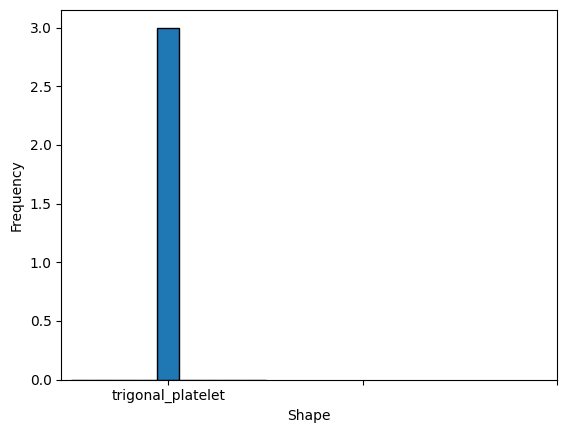

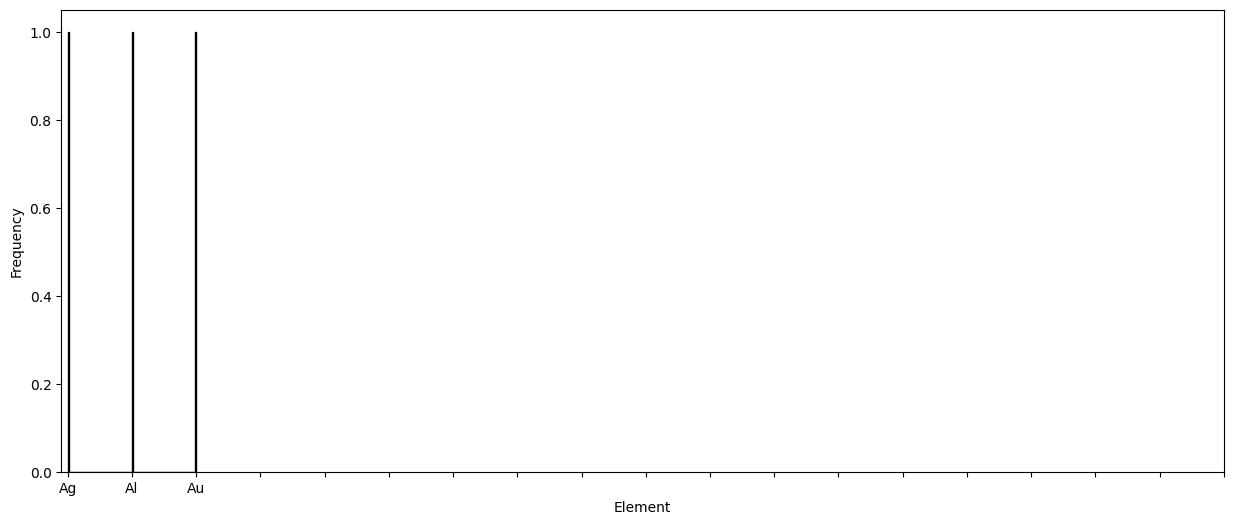

In [16]:

# On va creer un graph qui permet de forme la distribution des formes de notre data frame
import matplotlib.pyplot as plt
# Créer la figure et les axes
fig, ax = plt.subplots()

# Tracer l'histogramme
ax.hist(data['Shape'], bins=9,edgecolor='black')

# Ajouter des labels aux axes
ax.set_xlabel('Shape')
ax.set_ylabel('Frequency')

# Personnaliser les intervalles de l'axe des x
x_ticks = range(0, 3)  # Plage de 0 à 3
plt.xticks(x_ticks)

# Afficher la figure
plt.show()
#--------------------------------------------------------

# On va creer un graph qui permet de forme la distribution des éléments de notre data frame

import matplotlib.pyplot as plt
# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(15,6))


# Tracer l'histogramme
ax.hist(data['Element'], bins=100,edgecolor='black')

# Ajouter des labels aux axes
ax.set_xlabel('Element')
ax.set_ylabel('Frequency')


# Personnaliser les intervalles de l'axe des x
x_ticks = range(0, 19)  # Plage de 0 à 50
plt.xticks(x_ticks)


# Afficher la figure

plt.show()